# 3 - Análise Exploratória e Consultas SQL

In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import duckdb
import scipy.stats as stats
import os

input_path = "air_quality.parquet"
out_folder = "./out"

os.makedirs(out_folder, exist_ok=True)
df_annual = pd.read_parquet(os.path.join(out_folder, "annual_air_quality.parquet"))
df_seasonal = pd.read_parquet(os.path.join(out_folder, "seasonal_air_quality.parquet"))

# Primeira Consulta

Essa consulta mostraria os anos em que a distribuição anual de PM2.5 em NYC
está dentro dos limites sugeridos pela OMS (10 µg/m³ até 2020 e 5 µg/m³ a partir
de 2021). Porém para mostrar os pontos num gráfico, não estamos filtrando fora os
anos que não atendem a esses critérios por um motivo de visualização.

Referência: https://www.who.int/news-room/feature-stories/detail/what-are-the-who-air-quality-guidelines \
Último Acesso em 14/11/25 23:59

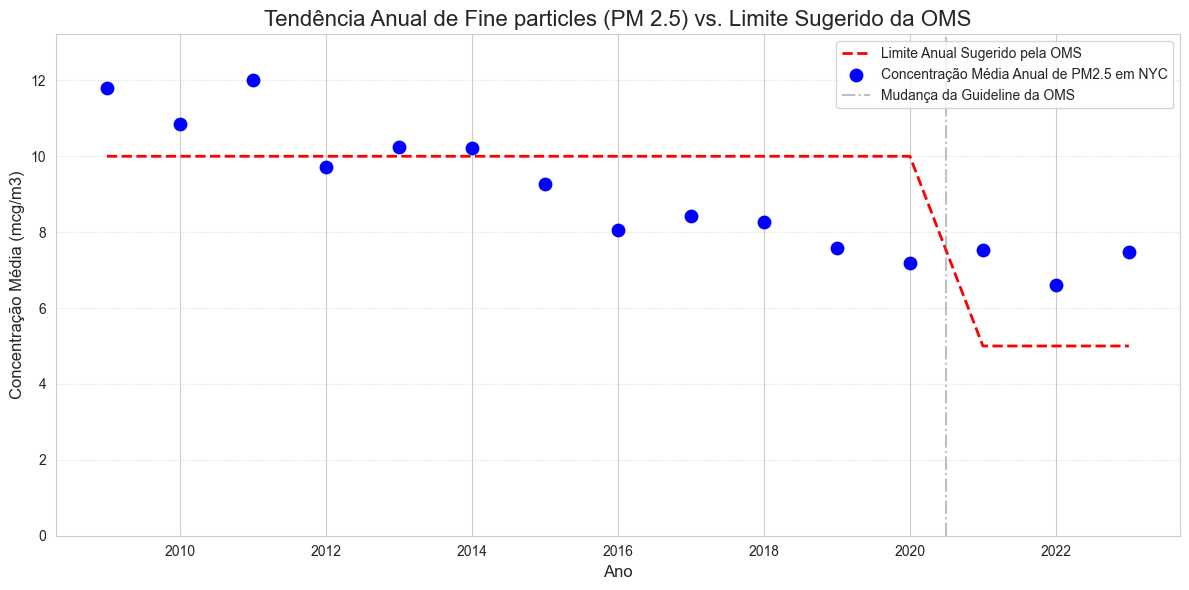

In [4]:
# select
#       *
# from 
#       (select indicatorid, name, year, avg(DataValue) as DataValue
# 		from data
# 		group by indicatorid, name, year
# 		having indicatorid = 365)
# where 
# 	    (year between 2005 and 2020 and datavalue <=10)
# 		    or
# 	    (year >= 2021 and datavalue <=5)
# order 
#       by year

df_pm25 = df_seasonal[df_seasonal['IndicatorID'] == 365].copy()

df_pm25_annual = df_pm25.groupby(['IndicatorID', 'Name', 'Year', 'MeasureInfo'], as_index=False)['DataValue'].mean()

df_pm25_annual['Limite_OMS'] = np.where(
    df_pm25_annual['Year'] <= 2020,
    10.0,
    5.0
)

plt.close('all')
plt.figure(figsize=(12,6))
sns.set_style("whitegrid")

# Se 'Limite_OMS' for 10 até 2020 e 5 depois, o plot conectará (2020, 10) a (2021, 5).
plt.plot(
    df_pm25_annual['Year'],
    df_pm25_annual['Limite_OMS'],
    color='red',
    linestyle='--',
    linewidth=2,
    label='Limite Anual Sugerido pela OMS'
)

plt.scatter(
    df_pm25_annual['Year'],
    df_pm25_annual['DataValue'],
    color='blue',
    s=80,
    zorder=3,
    label='Concentração Média Anual de PM2.5 em NYC'
)

# Adicionar Linha Vertical para a Mudança de Regra
plt.axvline(x=2020.5, color='gray', linestyle='-.', alpha=0.5, label='Mudança da Guideline da OMS')

# Ajustar altura do eixo Y
y_max = df_pm25_annual['DataValue'].max()
plt.ylim(0, y_max * 1.1)

plt.title(f'Tendência Anual de {df_pm25_annual["Name"].iloc[0]} vs. Limite Sugerido da OMS', fontsize=16)
plt.xlabel('Ano', fontsize=12)
plt.ylabel(f'Concentração Média ({df_pm25_annual["MeasureInfo"].iloc[0]})', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, axis='y', linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()


# Segunda Consulta

Distribuição de Dióxido de Nitrogênio (NO2) ao longo dos anos por estação utilizando a medida de partes por bilhão (ppb)

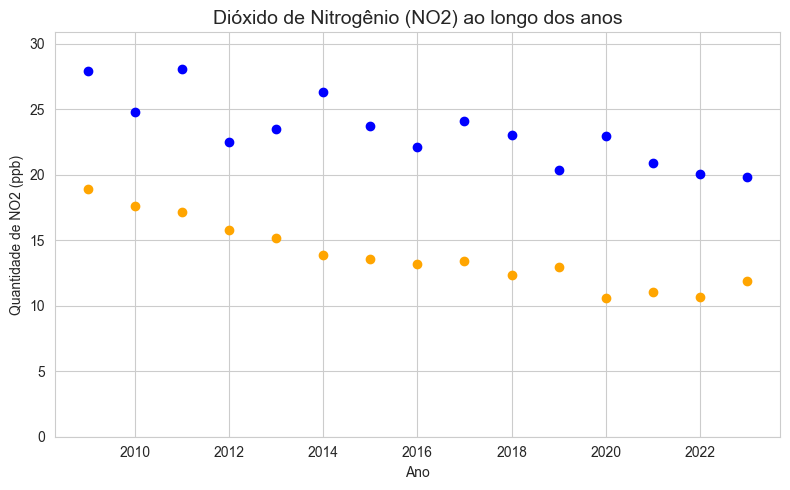

In [5]:
# select
#     season, year, DataValue
# from
#     data
# where
#     indicatorid = 375;

df_no2_seasonal = df_seasonal[df_seasonal['IndicatorID'] == 375].copy()

# O anual é utilizado na análsie de hipótese
df_no2_annual = df_no2_seasonal.groupby(['IndicatorID', 'Name', 'Year', 'MeasureInfo'], as_index=False)['DataValue'].mean()

plt.figure(figsize=(8, 5))
plt.title("Dióxido de Nitrogênio (NO2) ao longo dos anos", fontsize=14)

y_max = df_no2_seasonal['DataValue'].max()
plt.ylim(0, y_max * 1.1)

plt.scatter(
    df_no2_seasonal[df_no2_seasonal["Season"] == "Summer"]["Year"],
    df_no2_seasonal[df_no2_seasonal["Season"] == "Summer"]["DataValue"],
    color="orange",
    label="Verão"
)

plt.scatter(
    df_no2_seasonal[df_no2_seasonal["Season"] == "Winter"]["Year"],
    df_no2_seasonal[df_no2_seasonal["Season"] == "Winter"]["DataValue"],
    color="blue",
    label="Inverno"
)

plt.xlabel("Ano")
plt.ylabel("Quantidade de NO2 (ppb)")
plt.tight_layout()
plt.show()

# Terceira Consulta

Taxa de variação de mortes devido ao PM 2.5 ao longo dos anos

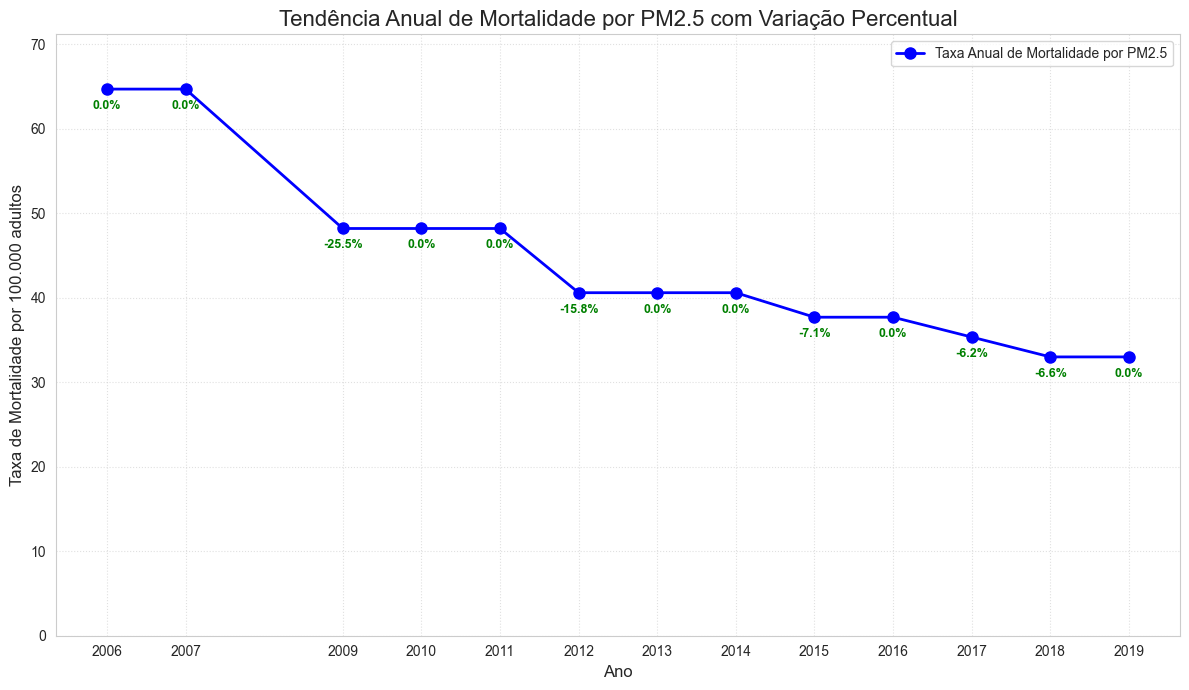

In [6]:
# Essa query cria duas colunas, uma que mantém o ano anterior, e a outra que calcula o DataValue 
# em relação ao ano anterior

sql_query = """
SELECT
    Year, DataValue,
    LAG(DataValue, 1) OVER (ORDER BY Year) AS DataValue_Anterior,
    (
        (DataValue - LAG(DataValue, 1) OVER (ORDER BY Year)) / 
        DataValue_Anterior
    ) * 100 AS Decrescimo_Percentual
FROM df_annual
WHERE IndicatorId = 639 -- Mortes devido ao PM2.5
ORDER BY Year
"""

df_resultado = duckdb.query(sql_query).df()
df_plot = df_resultado.dropna(subset=['Decrescimo_Percentual']).copy()

plt.figure(figsize=(12, 7))

y_max = df_plot['DataValue'].max()
plt.ylim(0, y_max * 1.1)

# Plotar a linha principal da DataValue (mortalidade)
plt.plot(df_plot['Year'], df_plot['DataValue'], 
         marker='o', linestyle='-', color='blue', linewidth=2, markersize=8,
         label='Taxa Anual de Mortalidade por PM2.5')

# Adicionar rótulos de texto para a variação percentual em cada ponto
for i, row in df_plot.iterrows():
    if pd.notna(row['Decrescimo_Percentual']):
        variacao_str = f"{row['Decrescimo_Percentual']:.1f}%"
        plt.text(row['Year'], row['DataValue'] - 2, 
                 variacao_str, 
                 color='green', ha='center', va='center', fontsize=9, 
                 weight='bold')



plt.title('Tendência Anual de Mortalidade por PM2.5 com Variação Percentual', fontsize=16)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Taxa de Mortalidade por 100.000 adultos', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)

plt.xticks(df_plot['Year'].unique())
plt.tight_layout()
plt.show()


# Aplicação da Hipotése 1

H1: "Haverá uma correlação negativa significativa entre o período do ano e a poluição
do ar"

Hipotése aplicada à PM2.5 e Dióxido de Nitrogênio (NO2)

Resultado: Hipótese totalmente falha, a hipótese se mostrou tendo uma correlação positiva entre o verão e o inverno pata o PM2.5 quanto para o NO2.

Coeficiente de Correlação (r) entre PM2.5 Verão e Inverno: 0.695
P-valor: 0.00406

Coeficiente de Correlação (r) entre NO2 Verão e Inverno: 0.765
P-valor: 0.00090

In [7]:
#TRATANDO PM2.5
df_pm25_summer = df_pm25[df_pm25['Season'] == 'Summer'].copy()
df_pm25_winter = df_pm25[df_pm25['Season'] == 'Winter'].copy()

r_pm25_summer_winter, p_value_PM25_summer_winter = stats.pearsonr(
    df_pm25_summer['DataValue'],
    df_pm25_winter['DataValue']
)

df_pm25_merged = pd.merge(
    df_pm25_summer[['Year', 'DataValue']].rename(columns={'DataValue': 'PM2.5_Summer'}),
    df_pm25_winter[['Year', 'DataValue']].rename(columns={'DataValue': 'PM2.5_Winter'}),
    on='Year'
)

r_pm25_summer_winter, p_value_PM25_summer_winter = stats.pearsonr(
    df_pm25_merged['PM2.5_Summer'],
    df_pm25_merged['PM2.5_Winter']
)

print(f"Coeficiente de Correlação (r) entre PM2.5 Verão e Inverno: {r_pm25_summer_winter:.3f}")
print(f"P-valor: {p_value_PM25_summer_winter:.5f}\n")

# TRATANDO NO2
df_no2_summer = df_no2_seasonal[df_no2_seasonal['Season'] == 'Summer'].copy()
df_no2_winter = df_no2_seasonal[df_no2_seasonal['Season'] == 'Winter'].copy()

df_no2_merged = pd.merge(
    df_no2_summer[['Year', 'DataValue']].rename(columns={'DataValue': 'NO2_Summer'}),
    df_no2_winter[['Year', 'DataValue']].rename(columns={'DataValue': 'NO2_Winter'}),
    on='Year'
)

r_no2_summer_winter, p_value_NO2_summer_winter = stats.pearsonr(
    df_no2_merged['NO2_Summer'],
    df_no2_merged['NO2_Winter']
)

print(f"Coeficiente de Correlação (r) entre NO2 Verão e Inverno: {r_no2_summer_winter:.3f}")
print(f"P-valor: {p_value_NO2_summer_winter:.5f}\n")


Coeficiente de Correlação (r) entre PM2.5 Verão e Inverno: 0.695
P-valor: 0.00406

Coeficiente de Correlação (r) entre NO2 Verão e Inverno: 0.765
P-valor: 0.00090



# Aplicação da Hipótese 2

H2: "O período passado é um bom preditor para dizer se a poluição do ar vai subir
ou diminuir no próximo ano".

Hipótese aplicada na maior resolução de dados possível para o conjunto enquanto fazendo uso de lag=1, isso significa que temos resultados para o verão/inverno de PM2.5, verão/inverno de NO2 e verão para O3. 
Resultados nos mostraram a possibilidade de utilizar regressão para fazer a correlação para todos indicadores exceto para o ozônio, o qual não mostrou correlação nenhuma com o mesmo período anterior.

--- Autocorrelação Sazonal(Verão) de PM2.5 ---
Coeficiente de Autocorrelação (r): 0.682
P-valor: 0.00724

--- Autocorrelação Sazonal(Inverno) de PM2.5 ---
Coeficiente de Autocorrelação (r): 0.630
P-valor: 0.01583

--- Autocorrelação Sazonal (Verão) de NO2 ---
Coeficiente de Autocorrelação (r): 0.934
P-valor: 0.00000

--- Autocorrelação Sazonal (Inverno) de NO2 ---
Coeficiente de Autocorrelação (r): 0.730
P-valor: 0.00702

--- Autocorrelação Anual de O3 ---
Coeficiente de Autocorrelação (r): 0.085
P-valor: 0.77211

In [8]:
# TRATANDO PM2.5

df_pm25_summer = df_pm25[df_pm25['Season'] == 'Summer'].copy()
df_pm25_summer['DataValue_Anterior'] = df_pm25_summer['DataValue'].shift(1)
df_pm25_summer = df_pm25_summer.dropna(subset=['DataValue_Anterior'])

df_pm25_winter = df_pm25[df_pm25['Season'] == 'Winter'].copy()
df_pm25_winter['DataValue_Anterior'] = df_pm25_winter['DataValue'].shift(1)
df_pm25_winter = df_pm25_winter.dropna(subset=['DataValue_Anterior'])

# print("DataFrame com Lag-1 Separado por Estação:")
# print(df_pm25annual[['Season', 'Year', 'DataValue', 'DataValue_Anterior']])

r_autocorrelacao_PM25_summer, p_value_PM25_summer = stats.pearsonr(
    df_pm25_summer['DataValue_Anterior'],
    df_pm25_summer['DataValue']
)

print(f"--- Autocorrelação Sazonal(Verão) de PM2.5 ---")
print(f"Coeficiente de Autocorrelação (r): {r_autocorrelacao_PM25_summer:.3f}")
print(f"P-valor: {p_value_PM25_summer:.5f}\n")

r_autocorrelacao_PM25_winter, p_value_PM25_winter = stats.pearsonr(
    df_pm25_winter['DataValue_Anterior'],
    df_pm25_winter['DataValue']
)

print(f"--- Autocorrelação Sazonal(Inverno) de PM2.5 ---")
print(f"Coeficiente de Autocorrelação (r): {r_autocorrelacao_PM25_winter:.3f}")
print(f"P-valor: {p_value_PM25_winter:.5f}\n")

# TRATANDO NO2
df_no2_summer = df_no2_seasonal[df_no2_seasonal['Season'] == 'Summer'].copy()
df_no2_summer['DataValue_Anterior'] = df_no2_summer['DataValue'].shift(1)
df_no2_summer = df_no2_summer.dropna(subset=['DataValue_Anterior'])

df_no2_winter = df_no2_seasonal[df_no2_seasonal['Season'] == 'Winter'].copy()
df_no2_winter['DataValue_Anterior'] = df_no2_winter['DataValue'].shift(3)
df_no2_winter = df_no2_winter.dropna(subset=['DataValue_Anterior'])

r_autocorrelacao_NO2_summer, p_value_NO2_summer = stats.pearsonr(
    df_no2_summer['DataValue_Anterior'],
    df_no2_summer['DataValue']
)

print(f"--- Autocorrelação Sazonal (Verão) de NO2 ---")
print(f"Coeficiente de Autocorrelação (r): {r_autocorrelacao_NO2_summer:.3f}")
print(f"P-valor: {p_value_NO2_summer:.5f}\n")

r_autocorrelacao_NO2_winter, p_value_NO2_winter = stats.pearsonr(
    df_no2_winter['DataValue_Anterior'],
    df_no2_winter['DataValue']
)

print(f"--- Autocorrelação Sazonal (Inverno) de NO2 ---")
print(f"Coeficiente de Autocorrelação (r): {r_autocorrelacao_NO2_winter:.3f}")
print(f"P-valor: {p_value_NO2_winter:.5f}\n")

# TRATANDO O3
df_o3 = df_seasonal[df_seasonal['IndicatorID'] == 386].copy()
df_o3['DataValue_Anterior'] = df_o3['DataValue'].shift(1)
df_o3 = df_o3.dropna(subset=['DataValue_Anterior'])

r_autocorrelacao_O3, p_value_O3 = stats.pearsonr(
    df_o3['DataValue_Anterior'],
    df_o3['DataValue']
)

print(f"\n--- Autocorrelação Anual de O3 ---")
print(f"Coeficiente de Autocorrelação (r): {r_autocorrelacao_O3:.3f}")
print(f"P-valor: {p_value_O3:.5f}")

--- Autocorrelação Sazonal(Verão) de PM2.5 ---
Coeficiente de Autocorrelação (r): 0.682
P-valor: 0.00724

--- Autocorrelação Sazonal(Inverno) de PM2.5 ---
Coeficiente de Autocorrelação (r): 0.630
P-valor: 0.01583

--- Autocorrelação Sazonal (Verão) de NO2 ---
Coeficiente de Autocorrelação (r): 0.934
P-valor: 0.00000

--- Autocorrelação Sazonal (Inverno) de NO2 ---
Coeficiente de Autocorrelação (r): 0.730
P-valor: 0.00702


--- Autocorrelação Anual de O3 ---
Coeficiente de Autocorrelação (r): 0.085
P-valor: 0.77211


# Aplicação da Hipótese 3

H3: "A concentração anual de PM2.5 apresenta uma relação maior com os indicadores de mortalidade do que com indicadores de morbidade".

Mortalidade - Coeficiente de Correlação (r): 0.944, P-valor: 0.00001
Emergências de Asma - Coeficiente de Correlação (r): 0.927, P-valor: 0.00004
Hospitaliz. Respiratórias - Coeficiente de Correlação (r): 0.850, P-valor: 0.00093
Hospitaliz. Cardiovasculares - Coeficiente de Correlação (r): 0.634, P-valor: 0.03611

In [9]:
sql_query = """
    SELECT Year, avg(DataValue) as PM25_Concentration
    FROM df_seasonal
    WHERE IndicatorID = 365
    GROUP BY Year
    ORDER BY Year
"""

df_pm25 = duckdb.query(sql_query).df()

sql_query = """
    SELECT Year, DataValue
    FROM df_annual
    WHERE IndicatorID = 639
    ORDER BY Year
"""

df_deaths_pm25 = duckdb.query(sql_query).df()

sql_query = """
    SELECT Year, avg(DataValue) as DataValue
    FROM df_annual
    WHERE IndicatorID = 648 OR IndicatorID = 657 -- Crianças e Adultos
    GROUP BY Year
    ORDER BY Year
"""

df_asthma_pm25 = duckdb.query(sql_query).df()

sql_query = """
    SELECT Year, DataValue
    FROM df_annual
    WHERE IndicatorID = 650
    ORDER BY Year
"""

df_respiratory_pm25 = duckdb.query(sql_query).df()

sql_query = """
    SELECT Year, DataValue
    FROM df_annual
    WHERE IndicatorID = 651
    ORDER BY Year
"""

df_cardiovascular_pm25 = duckdb.query(sql_query).df()

health_data = [
    (df_deaths_pm25.copy(), 'Mortalidade'),
    (df_asthma_pm25.copy(), 'Emergências de Asma'),
    (df_respiratory_pm25.copy(), 'Hospitaliz. Respiratórias'),
    (df_cardiovascular_pm25.copy(), 'Hospitaliz. Cardiovasculares')
]

for df_health, name in health_data:
    df_merged = pd.merge(df_pm25[['Year', 'PM25_Concentration']], 
                         df_health[['Year', 'DataValue']], 
                         on='Year', 
                         how='inner')

    r, p = stats.pearsonr(df_merged['PM25_Concentration'], df_merged['DataValue'])
    print(f"{name} - Coeficiente de Correlação (r): {r:.3f}, P-valor: {p:.5f}")


Mortalidade - Coeficiente de Correlação (r): 0.944, P-valor: 0.00001
Emergências de Asma - Coeficiente de Correlação (r): 0.927, P-valor: 0.00004
Hospitaliz. Respiratórias - Coeficiente de Correlação (r): 0.850, P-valor: 0.00093
Hospitaliz. Cardiovasculares - Coeficiente de Correlação (r): 0.634, P-valor: 0.03611
